# Name: Luke Pratley


# Feature + Label Engineering and Processing

The purpose of this notebook is to create the final images and labels used for training.

The final outputs are `.png` RGB files with their corresponding boolean masks for building and road networks.


In [4]:
%matplotlib inline
import sys, os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps

import glob
import os


import rasterio
import rasterio.features
from rasterio.merge import merge
from rasterio.plot import show
import geopandas as gpd

First we create lists of the file paths:

In [5]:
data_directory = 'D:\Capstone Project\data\\'

In [6]:
X_paths = glob.glob(data_directory +'final_images\\*')
y_paths = [glob.glob(data_directory +'final_masks\\road_*'), glob.glob(data_directory +'final_masks\\building_*')]

The `X_paths` list is the list of paths to RGB images.

The `y_paths` list is a list of paths to both road and building pixel masks.

First we check that all of the corresponding paths are indexed correctly, e.g., index `k` provides the right mask for the chosen RGB image.

In [7]:
for k in range(len(X_paths)):
    n1 = X_paths[k].split("\\")[-1].replace(".npy", '')
    n2 = y_paths[0][k].split("road_mask_")[-1].replace(".npy", '')
    n3 = y_paths[1][k].split("building_mask_")[-1].replace(".npy", '')
    assert n1 == n2
    assert n2 == n3

Below we find that we have 19,646 images.

In [12]:
len(X_paths)

19646

Here is an example of the list elements:

In [11]:
print(X_paths[40])
print(y_paths[0][40])
print(y_paths[1][40])

D:\Capstone Project\data\final_images\AOI_2_Vegas_img1073.npy
D:\Capstone Project\data\final_masks\road_mask_AOI_2_Vegas_img1073.npy
D:\Capstone Project\data\final_masks\building_mask_AOI_2_Vegas_img1073.npy


### Image Processing
The loop below performs image processing and saves the final input features and target labels for training.

Some key points:

- The python [Pillow](https://pillow.readthedocs.io/en/stable/) module is used to down sample the images to 128 by 128 pixels. To save on space, the RGB images are converted to png. Also, if there are not enough pixels for a road to cross an image, we remove the road labels for that input image.
- To help with contrast issues, [histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) is used to balance the brightness levels where possible. This improved the quality during training substantially.
- One issue with the road masks is that the lines are only one pixel thin. The road masks are convolved/blurred using a Gaussian filter that has a radius of 5 pixels. This produces roads that are thick and easier to interpret.
- The road and building masks are independent in the sense that a pixel can be classified as having both a road and building in the same location. I found that this is possible because the pictures are not always top down, and a building might be blocking a section of the road in a photo due to the angle that the photo was taken.
- If an RGB image has more than 20% of its pixels as zeros, then it is not used for training.
- If both masks start with values of -1, then the image is not used for training.




In [13]:
new_size = (128, 128)
from PIL.ImageFilter import (
    GaussianBlur
    )
for k in range(len(X_paths)):
    if not os.path.exists("final_masks_small\\" + X_paths[k].split("\\")[-1].replace(".npy", '') + '.npy'):
        m0 = np.load(y_paths[0][k]).astype(int)
        m1 = np.load(y_paths[1][k]).astype(int)
        rast_img = np.load(X_paths[k])
        array = np.clip(rast_img/np.max(rast_img) * 255, 0, 255).astype(np.uint8)
        fraction_nonnans = (rast_img.size - np.count_nonzero(rast_img))/rast_img.size
        dynamic_range= np.max(array)
        if (np.sum(m0)  < 600):       
            m0 = m0 * 0 - 1

        if (np.all(m0 >= 0) or np.all(m1 >= 0)) and (fraction_nonnans < 0.2):

            img_mask = [np.array(Image.fromarray(m0 * 255).convert('L').filter(GaussianBlur(radius=5)).resize(new_size, Image.BICUBIC)) if (np.sum(m0)  >= 600) else np.ones(new_size) * -255, 
                        np.array(Image.fromarray(m1).convert('L').resize(new_size,Image.BICUBIC))]
            mask = np.moveaxis(img_mask, 0, 2)/255.
            # we are marking masks that have missing or no labels as -1. This allows us to censor during the training process.
            mask[:, :, 0] = np.clip(np.ceil(mask[:, :, 0]), 0, 1) if np.sum(mask[:, :, 0]) > 0 else -1.
            mask[:, :, 1] = np.clip(np.ceil(mask[:, :, 1]), 0, 1) if np.sum(mask[:, :, 1]) > 0 else -1.
            np.save("final_masks_small\\" + X_paths[k].split("\\")[-1].replace(".npy", '') + '.npy', mask)
            img = Image.fromarray(array)
            img = PIL.ImageOps.equalize(img)
            img = img.resize(new_size,Image.BICUBIC)
            img.save("final_images_small\\" + X_paths[k].split("\\")[-1].replace(".npy", '') + '.png')
        if k % 1000 == 0:
            print(f'{k}')

0


C:\Users\lukep\AppData\Local\Temp\ipykernel_23064\4275508094.py:10: RuntimeWarning: invalid value encountered in true_divide
  array = np.clip(rast_img/np.max(rast_img) * 255, 0, 255).astype(np.uint8)


13000


## Inspecting the output

We can view images and masks that have been processing and that can be used for training. The reduced image size helps to reduce the computation time of training and the memory required for training.

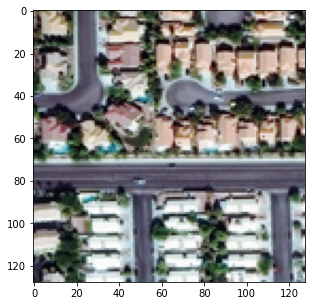

In [17]:
plt.figure(figsize=(5, 5))
img = Image.open("final_images_small\AOI_2_Vegas_img1073.png")
array = np.array(img).astype(np.uint8)
plt.imshow(array)

A road mask/label. You can see that the roads have a width due to the Gaussian convolution kernel that was applied.

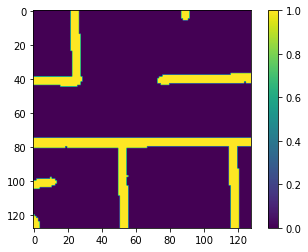

In [18]:
mask = np.load("final_masks_small\\AOI_2_Vegas_img1073.npy")
plt.imshow(mask[:, :, 0])
plt.colorbar()

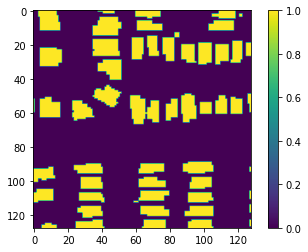

In [19]:
mask = np.load("final_masks_small\\AOI_2_Vegas_img1073.npy")
plt.imshow(mask[:, :, 1])
plt.colorbar()